In [4]:

import warnings
warnings.simplefilter(action='ignore')

import seaborn as sns 
import numpy as np
import pandas as pd 
import pathlib
import json 
from matplotlib import pyplot as plt 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 18, 'lines.markeredgewidth': 5})


color_mapping = {"baseline": "#ca0020", "no dilution": "#0571b0", "group DRO": "#f4a582", "upsample": "#e6550d" , "upsample 32x": "#1b7837"}
# color_mapping = {"baseline": "#542788", "no dilution": "#998ec3", "group DRO": "#d8daeb", "upsample": "#f1a340", "upsample 32x": "#b35806"}

# marker_lookup = {'baseline'play_radio': "d", "FindManager": "o", 'email_query': "H", "Tomorrow": "P", 'email_querycontact': "^", "PlaceHasFeature": ">", 'general_quirky': "s", "DoNotConfirm": "p", 'traffic': "8", "FenceAttendee": "*", "total": "D"}

marker_lookup = {"baseline": "d", "no dilution": "o", "upsample": "^", "group DRO": "s", "upsample 32x": "h"}

name_lookup = {"valid_em": "Exact Match", "valid_coarse": "Coarse", "valid_fine": "Fine", "valid_precision": "Precision", 
               "test_em": "Exact Match", "test_coarse": "Coarse", "test_fine": "Fine", "test_precision": "Precision"}

setting_lookup = {"5000": "5k", "10000": "10k", "20000": "20k", "50000": "50k", "100000": "100k",
                  "750": "0.75k", "1500": "1.5k", "3000": "3k", "7500": "7.5k", "15000": "15k", "18000": "max"}

In [10]:
def plot_calflow(paths_and_fxns,
                title, 
                savepath=None, 
                fixed_axis=False, 
                prefix="valid", 
                xs = ["5000","10000","20000","50000","100000","max"], 
                ax = None, 
                use_total=True, 
                use_coarse=False, 
                add_nums=False, 
                hue_var="type",
                ymin = None, 
                ymax=None,
                show_legend=False,
                legend_kws={}):

    df = pd.DataFrame(columns=['fxn', 'train', 'examples', 'seed', 'acc', 'type'], dtype=object)
    for fxn, path, type_name in paths_and_fxns:
        single_df = pd.read_csv(path, index_col=0)
        single_df = single_df[single_df['function'] == 100]
        col_names = ['train', 'function', 'seed', 'test_em']
        single_df = single_df[col_names]

        single_df = single_df.rename(columns={"function": "examples", "seed": "seed", "train": "train", "test_em": "acc", "total": "acc"})
        single_df['fxn'] = [fxn for i in range(len(single_df))]
        single_df['type'] = [type_name for i in range(len(single_df))]
        df = df.append(single_df, ignore_index=True)

    if ax is None:
        fig, ax = plt.subplots()

    sns.lineplot(data=df, 
                x="train", 
                y="acc",  
                hue=hue_var, 
                err_style='band', 
                style = hue_var, 
                markers=marker_lookup,
                dashes=False,
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
                
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    if ymax is not None:
        ax.set_ylim(top=ymax)

    # labels = ax.get_xticklabels()
    # ax.set_xticklabels([setting_lookup[lab] for lab in labels])
    ax.set_xticklabels(['5k', '10k', '20k', '50k', '100k', 'max'])
    # sns.set(font_scale = 1.1)
    ax.set_title(title, fontsize=16, fontfamily="DejaVu Serif")
    ax.set_ylabel("")
    # ax.set_xlabel("Total Training Examples")
    ax.set_xlabel("") 


    if show_legend: 
        ax.legend(**legend_kws)
    else:
        ax.legend([], [], frameon=False)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)



In [11]:
def get_data_from_dir(root_data_dirs_and_settings, fxn, seeds):
    all_data = pd.DataFrame(columns=["train", "function", "seed", "type", "total_acc", f"{fxn}_acc", "intent"], dtype=object)
    for root_data_dir, type_name in root_data_dirs_and_settings:
        root_data_dir = pathlib.Path(root_data_dir).joinpath(str(fxn))
        for seed in seeds:
            data_dir = root_data_dir.joinpath(f"{seed}_seed")
            globs = [x for x in data_dir.glob("*/test_metrics.json")]
            globs = sorted(globs, key = lambda x: int(x.parent.name.split("_")[0]))
            for path in globs:
                try:
                    data = json.load(open(path))
                except json.JSONDecodeError:
                    print(f"json decode error on {path}")
                    data = {}
                    data['acc'] = np.nan
                    data[f'{fxn}_acc'] = np.nan

                setting = path.parent.name
                num_train, num_fxn = setting.split("_")
                num_train, num_fxn = int(num_train), int(num_fxn)

                # if seed == 12 and type_name == "no dilution" and num_fxn == 15 and num_train == 750:
                    # print(data)

                to_add = {"train": str(num_train), "function": num_fxn, "seed": seed, "type": type_name, 
                        "total_acc": data['acc'] * 100, "intent": fxn, f"{fxn}_acc": data[f"{fxn}_acc"] * 100}
                all_data = all_data.append(to_add, ignore_index=True)

    return all_data 

name_mapping = {"50": "play_radio", "66": "traffic", "15": "email_query", "16": "email_querycontact", "27": "general_quirky"}
def plot_intent(data_dirs, 
                intent, 
                seeds = [12, 31, 64], 
                title=None, 
                savepath=None, 
                fixed_axis=False, 
                xs = [750, 1500, 3000, 7500, 15000, 18000], 
                ax = None, 
                fxn_split = 15,
                axis_title = None,
                show_legend=False, 
                legend_kws = {}):

    data = get_data_from_dir(data_dirs, intent, seeds)
    pre_data = data
    data = data[data['function'] == fxn_split]
    col_names = ["train", "seed", f"total_acc", "type"]
    minor_data = data[col_names]
    minor_data = minor_data.rename(columns={"train": "train", 
                                    f"total_acc": name_mapping[str(intent)]})
    if ax is None:
        fig, ax = plt.subplots()

    sns.lineplot(data=minor_data, 
                x="train", 
                y=name_mapping[str(intent)],  
                hue="type", 
                err_style='band',
                markers=marker_lookup,
                style="type",
                dashes=False,
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    ax.set_title(title, fontsize=16, fontfamily="DejaVu Serif")
    ax.set_ylabel("")

    if axis_title is not None:
        ax.set_xlabel("Total Training Examples")
    else:
        ax.set_xlabel("") 

    # labels = ax.get_xticklabels()
    ax.set_xticklabels(['0.75k', '1.5k', '3k', '7.5k', '15k', 'max'])
    if show_legend:
        ax.legend(**legend_kws)
    else:
        ax.legend([], [], frameon=False)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)
    return pre_data

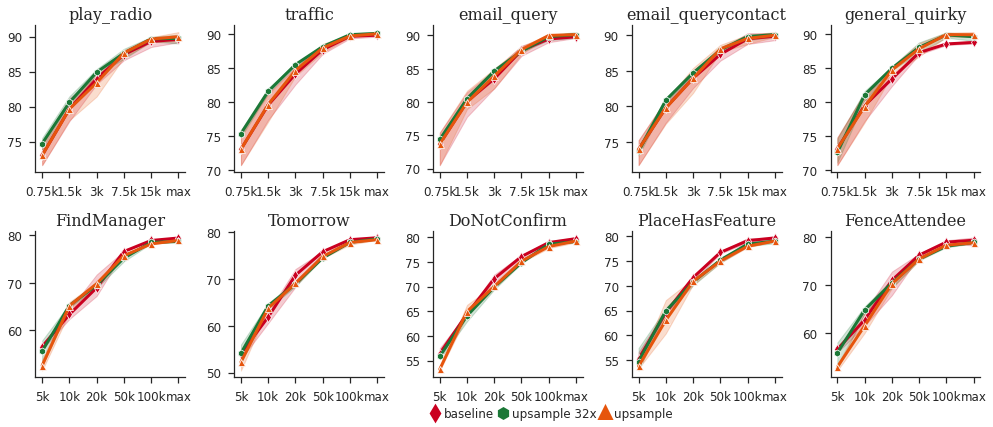

In [12]:

from matplotlib.legend_handler import HandlerLine2D

fm_baseline_path = "~/papers/incremental_function_learning/results/FindManager_transformer_test.csv"
fm_upsample_flat_path = "~/papers/incremental_function_learning/results/upsample/FindManager_upsample_32.csv"
fm_upsample_path = "~/papers/incremental_function_learning/results/FindManager_upsample_constant.csv"
fm_paths_and_fxns = [("FindManager", fm_baseline_path, "baseline"), 
                     ("FindManager", fm_upsample_flat_path, "upsample 32x"),
                     ("FindManager", fm_upsample_path, "upsample")]


tom_baseline_path = "~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv"
tom_upsample_flat_path = "~/papers/incremental_function_learning/results/upsample/Tomorrow_upsample_32.csv"
tom_upsample_path = "~/papers/incremental_function_learning/results/Tomorrow_upsample_constant.csv"
tom_paths_and_fxns = [("Tomorrow", tom_baseline_path, "baseline"), 
                      ("Tomorrow", tom_upsample_flat_path, "upsample 32x"),
                      ("Tomorrow", tom_upsample_path, "upsample")]

dnc_baseline_path = "~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv"
dnc_upsample_flat_path = "~/papers/incremental_function_learning/results/upsample/DoNotConfirm_upsample_32.csv"
dnc_upsample_path = "~/papers/incremental_function_learning/results/DoNotConfirm_upsample_constant.csv"
dnc_paths_and_fxns = [("DoNotConfirm", dnc_baseline_path, "baseline"), 
                      ("DoNotConfirm", dnc_upsample_flat_path, "upsample 32x"),
                      ("DoNotConfirm", dnc_upsample_path, "upsample")]

phf_baseline_path = "~/papers/incremental_function_learning/results/PlaceHasFeature_transformer_test.csv"
phf_upsample_flat_path = "~/papers/incremental_function_learning/results/upsample/PlaceHasFeature_upsample_32.csv"
phf_upsample_path = "~/papers/incremental_function_learning/results/PlaceHasFeature_upsample_constant.csv"
phf_paths_and_fxns = [("PlaceHasFeature", phf_baseline_path, "baseline"), 
                      ("PlaceHasFeature", phf_upsample_flat_path, "upsample 32x"),
                      ("PlaceHasFeature", phf_upsample_path, "upsample")]

fa_baseline_path = "~/papers/incremental_function_learning/results/FenceAttendee_transformer_test.csv"
fa_upsample_flat_path = "~/papers/incremental_function_learning/results/upsample/FenceAttendee_upsample_32.csv"
fa_upsample_path = "~/papers/incremental_function_learning/results/FenceAttendee_upsample_constant.csv"
fa_paths_and_fxns = [("FenceAttendee", fa_baseline_path, "baseline"), 
                     ("FenceAttendee", fa_upsample_flat_path, "upsample 32x"),
                     ("FenceAttendee", fa_upsample_path, "upsample")]


all_paths = {"FindManager": fm_paths_and_fxns, "Tomorrow": tom_paths_and_fxns, "DoNotConfirm": dnc_paths_and_fxns, "PlaceHasFeature": phf_paths_and_fxns, "FenceAttendee": fa_paths_and_fxns}

# sns.set_theme(style="ticks", context = "paper") 
sns.set(context='paper')
sns.set(font_scale = 1.08)
sns.set_style(style='ticks')

fig, ax = plt.subplots(2, 5, figsize=(14,5.9), sharex=False, sharey=False)
for i, fxn in enumerate(["FindManager", "Tomorrow", "DoNotConfirm", "PlaceHasFeature", "FenceAttendee"]): 
    plot_calflow(all_paths[fxn], fxn, show_legend=False, ax=ax[1,i])

data_dirs = [("/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_shuffle/", "baseline"),
             ("/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/", "upsample 32x"),
             ("/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_constant_/", "upsample")]

data_by_fxn = {}
for i, intent in enumerate([50, 66, 15, 16, 27]): 
    show_legend=False
    data = plot_intent(data_dirs, intent, title=name_mapping[str(intent)], show_legend=show_legend,  ax=ax[0,i], fxn_split=30)
    data_by_fxn[intent] = data
    
lines, handles = ax[0,0].get_legend_handles_labels()

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(0)

handler_map={plt.Line2D : HandlerLine2D(update_func=update)}

legend_kws = dict(ncol=5, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5, markerscale=1.2,
                bbox_to_anchor=(0.68, -0.02), loc=4, handletextpad=0.5, handler_map=handler_map)

fig.legend(lines, handles, **legend_kws)

plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/large_main_new.pdf", bbox_inches='tight')